# Map-based simulation for elliptical beam convolution

## Here, we introduce how to assess elliptical beam systematics by the map-based simulation in the case of a single detector on the boresight.


In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from sbm import Field, ScanFields, SignalFields
import sbm
import sys
sys.version

'3.10.15 | packaged by conda-forge | (main, Oct 16 2024, 01:24:24) [GCC 13.3.0]'

# Load the cross-link on the boresight detector

## Input map: CMB (r=0)


In [2]:
scan_field = ScanFields.load_det("boresight/boresight")
r = 0.0
nside = 512
lmax = 3*nside-1
fwhm = np.deg2rad(1.0)
fiducial_map = sbm.generate_cmb(nside, r, cmb_seed=12345)
alm = hp.map2alm(fiducial_map)
smooth_alm = hp.smoothalm(alm,fwhm, inplace=False)
smooth_map = hp.alm2map(smooth_alm,nside)

# Make a elliptical beam

In [3]:
q = 0.9 # beam ellipticity
beam = sbm.elliptical_beam(nside, fwhm, q)
blm = hp.map2alm(beam)

In [ ]:
mdim = 3
signal_field = sbm.SignalFields.elliptical_beam_field(scan_field, mdim, alm, blm)

# Solve the liner system

Here, we perform the map-making by 3x3 matrix.

In [5]:
scan_field.xlink_threshold = 1
output_map = scan_field.map_make(signal_field)
residual = smooth_map - output_map

# Let's check the Input/Output/Residual maps

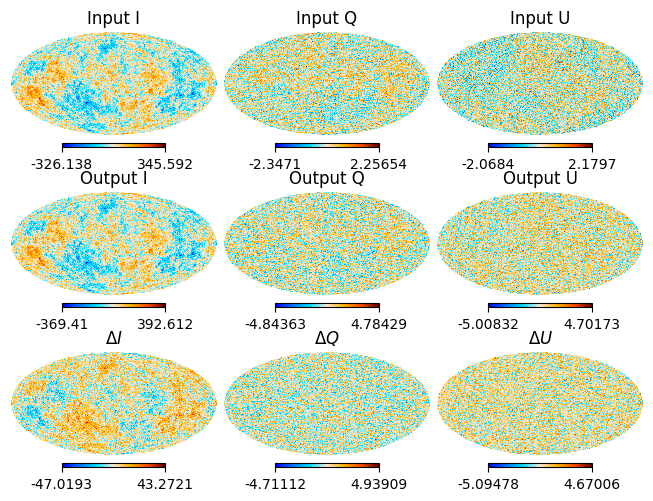

In [6]:
cmap = sbm.get_cmap()
hp.mollview(smooth_map[0], title="Input I", sub=(3,3,1), cmap=cmap)
hp.mollview(smooth_map[1], title="Input Q", sub=(3,3,2), cmap=cmap)
hp.mollview(smooth_map[2], title="Input U", sub=(3,3,3), cmap=cmap)

# SBM does not reconstruct I if `only_iqu`` is True
hp.mollview(output_map[0], title="Output I", sub=(3,3,4), cmap=cmap)
hp.mollview(output_map[1], title="Output Q", sub=(3,3,5), cmap=cmap)
hp.mollview(output_map[2], title="Output U", sub=(3,3,6), cmap=cmap)

hp.mollview(residual[0], title="$\Delta I$", sub=(3,3,7), cmap=cmap)
hp.mollview(residual[1], title="$\Delta Q$", sub=(3,3,8), cmap=cmap)
hp.mollview(residual[2], title="$\Delta U$", sub=(3,3,9), cmap=cmap)

# Let's check the power spectra

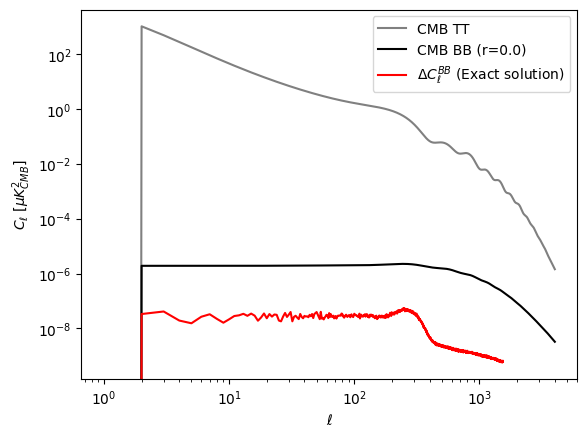

In [7]:
fiducial_cl = sbm.load_fiducial_cl(r)
res_cl = hp.anafast(residual)
delta_cl = res_cl[2] 
ell = np.arange(len(fiducial_cl[0]))

plt.plot(fiducial_cl[0], label="CMB TT", color="gray")
plt.plot(fiducial_cl[2], label=f"CMB BB (r={r})", color="black")
plt.plot(
    res_cl[2] ,
    label="$\Delta C_\ell^{BB}$ (Exact solution)",
    color="red",
)  # deconvolution

plt.xlabel("$\ell$")
plt.ylabel("$C_\ell ~ [\mu K_{CMB}^2]$")
plt.xscale("log")
plt.yscale("log")
plt.legend();

Δr = 2.5458982424590354e-05


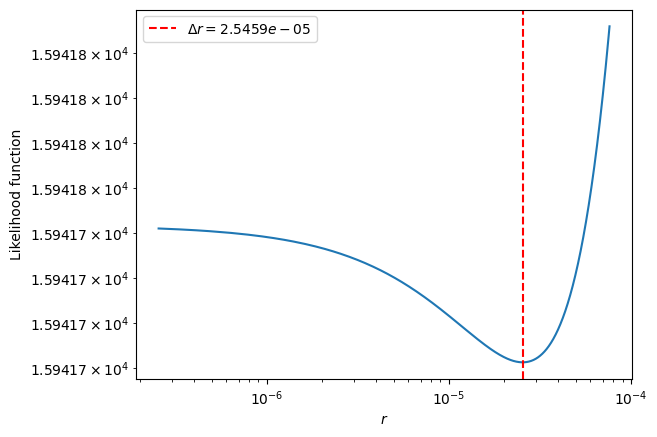

In [8]:
lmax_likelihood = 191
data = sbm.forecast(delta_cl, lmax=lmax_likelihood)
print(f"Δr = {data['delta_r']}")

dr = np.round(data["delta_r"], 9)
plt.plot(data["grid_r"], data["likelihood"], "-")
plt.axvline(data["delta_r"], color="red", label=f"$\Delta r = {dr}$", linestyle="--")
plt.xlabel("$r$")
plt.ylabel("Likelihood function")

plt.yscale("log")
plt.xscale("log")
plt.legend();

# Mitigation method

By chapturing $spin$-$\pm$4 component, we can avoid to have polarization-to-polarization leakage.
To do it, we expand the matrx size 3x3 to 5x5 as below


In [9]:
mdim = 5
signal_field = sbm.SignalFields.elliptical_beam_convolution(scan_field, mdim, alm, blm)

In [10]:
scan_field.xlink_threshold = 1
output_map = scan_field.map_make(signal_field)
residual = smooth_map - output_map

# Let's check the Input/Output/Residual maps

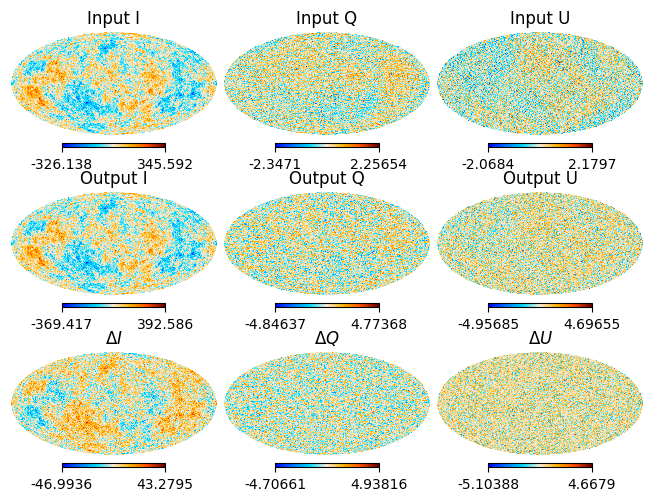

In [11]:
cmap = sbm.get_cmap()
hp.mollview(smooth_map[0], title="Input I", sub=(3,3,1), cmap=cmap)
hp.mollview(smooth_map[1], title="Input Q", sub=(3,3,2), cmap=cmap)
hp.mollview(smooth_map[2], title="Input U", sub=(3,3,3), cmap=cmap)

hp.mollview(output_map[0], title="Output I", sub=(3,3,4), cmap=cmap)
hp.mollview(output_map[1], title="Output Q", sub=(3,3,5), cmap=cmap)
hp.mollview(output_map[2], title="Output U", sub=(3,3,6), cmap=cmap)

hp.mollview(residual[0], title="$\Delta I$", sub=(3,3,7), cmap=cmap)
hp.mollview(residual[1], title="$\Delta Q$", sub=(3,3,8), cmap=cmap)
hp.mollview(residual[2], title="$\Delta U$", sub=(3,3,9), cmap=cmap)

# Let's check the power spectra

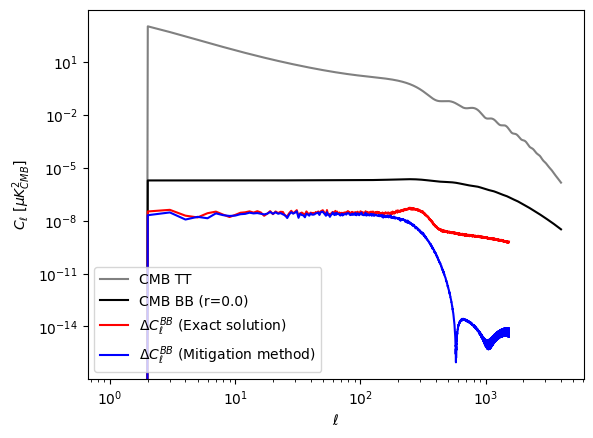

In [12]:
fiducial_cl = sbm.load_fiducial_cl(r)
res_cl_5by5 = hp.anafast(residual)
delta_cl_5by5 = res_cl_5by5[2] 
ell = np.arange(len(fiducial_cl[0]))

plt.plot(fiducial_cl[0], label="CMB TT", color="gray")
plt.plot(fiducial_cl[2], label=f"CMB BB (r={r})", color="black")
plt.plot(
    res_cl[2] ,
    label="$\Delta C_\ell^{BB}$ (Exact solution)",
    color="red",
)  
plt.plot(
    res_cl_5by5[2] ,
    label="$\Delta C_\ell^{BB}$ (Mitigation method)",
    color="blue",
)  


plt.xlabel("$\ell$")
plt.ylabel("$C_\ell ~ [\mu K_{CMB}^2]$")
plt.xscale("log")
plt.yscale("log")
plt.legend();

Δr = 1.8888455360225054e-05


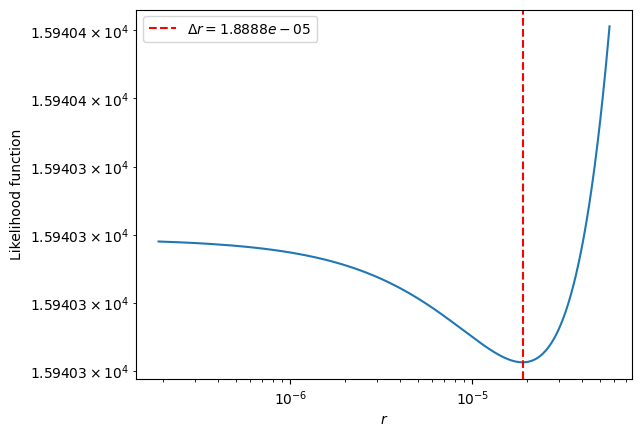

In [13]:
lmax_likelihood = 191
data = sbm.forecast(delta_cl_5by5, lmax=lmax_likelihood)
print(f"Δr = {data['delta_r']}")

dr = np.round(data["delta_r"], 9)
plt.plot(data["grid_r"], data["likelihood"], "-")
plt.axvline(data["delta_r"], color="red", label=f"$\Delta r = {dr}$", linestyle="--")
plt.xlabel("$r$")
plt.ylabel("Likelihood function")

plt.yscale("log")
plt.xscale("log")
plt.legend();